# Módulo 4: Teoría Moderna de Carteras y Optimización

## Modelo de Valoración de Activos de Capital (CAPM) y Riesgo

El **CAPM** es una medida clásica del **costo de capital**. Se utiliza para evaluar el precio de los activos y para medir el impacto de la prima de riesgo del mercado. También se relaciona con teorías más generales como la **Arbitrage Pricing Theory (APT)**.  

---

#### Riesgo Idiosincrático vs. Riesgo Sistemático

- **Riesgo idiosincrático:** Es específico de la empresa y puede diversificarse (p.ej., cambio de gestión, fallo en producción).  
- **Riesgo sistemático:** Afecta a todo el mercado y no puede diversificarse (p.ej., recesión económica, cambio en tasas de interés).  

A medida que un portafolio tiene más activos, los **riesgos idiosincráticos se cancelan**, y solo queda el **riesgo sistemático**.  
Para compensar este riesgo sistemático, los inversores reciben una **prima de riesgo** sobre la tasa libre de riesgo.

---

#### Prima de riesgo y Beta

La **prima de riesgo de un activo** no depende de su riesgo idiosincrático, sino de su **riesgo sistemático**.  
- Para medirlo, se estima cómo los **cambios en el retorno excesivo del activo** se relacionan con los cambios en el **retorno excesivo del mercado**.  
- Esto se expresa mediante una **regresión lineal**, donde la pendiente (β) indica la **sensibilidad del activo a shocks del mercado**.  

Si usamos un índice como el **S&P 500** como proxy del mercado:

$$
R_i - R_f = \beta_i (R_m - R_f)
$$

donde:  
- $R_i$: retorno del activo  
- $R_f$: tasa libre de riesgo  
- $R_m$: retorno del mercado  
- $\beta_i$: medida de riesgo sistemático  

Esta es la **definición del CAPM**, que establece que el retorno esperado de un activo es la tasa libre de riesgo más una compensación por su exposición al riesgo sistemático.

---

#### Resumen conceptual

El CAPM determina el **retorno mínimo esperado** para atraer inversores a un activo, combinando:  
1. La **tasa libre de riesgo** (inflación y valor temporal del dinero)  
2. Una **prima de riesgo proporcional al riesgo sistemático** del activo


/var/folders/g9/dx5m2_695pz6qb35ldcsltfw0000gn/T/ipykernel_49279/4278333964.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  AAPL_beta = AAPL_results.params[1]


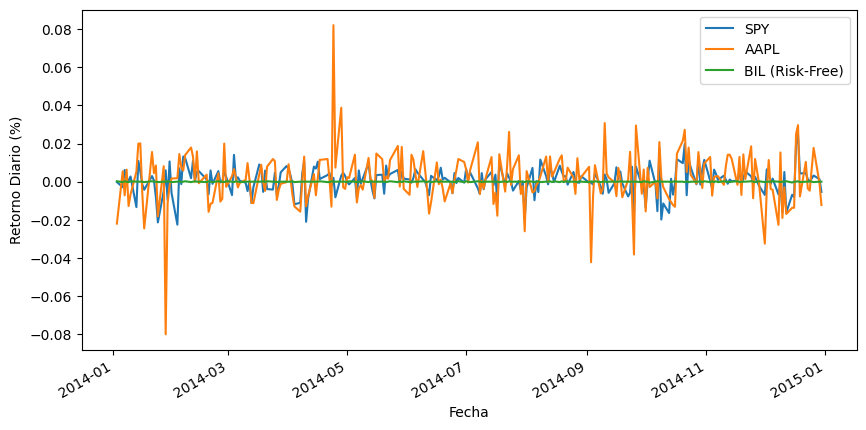

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     57.67
Date:                Mon, 15 Sep 2025   Prob (F-statistic):           6.30e-13
Time:                        21:14:20   Log-Likelihood:                 746.36
No. Observations:                 250   AIC:                            -1489.
Df Residuals:                     248   BIC:                            -1482.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.391      0.165      -0.000       0.003
Close          0.8376      0.110      7.594      0.000       0.620       1.055
==============================================================================
Omnibus:                       75.941   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2557.896
Skew:                          -0.352   Prob(JB):                         0.00
Kurtosis:                      18.654   Cond. No.                         142.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2]:
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Fechas
start_date = '2014-01-01'
end_date = '2014-12-31'

# Tickers
aapl = yf.Ticker("AAPL")
bil = yf.Ticker("BIL")
spy = yf.Ticker("SPY")

# Retornos diarios
R = aapl.history(start=start_date, end=end_date)['Close'].pct_change()[1:]
R_F = bil.history(start=start_date, end=end_date)['Close'].pct_change()[1:]
M = spy.history(start=start_date, end=end_date)['Close'].pct_change()[1:]

# Regresión lineal para encontrar beta de AAPL respecto al mercado
AAPL_results = sm.OLS(R - R_F, sm.add_constant(M)).fit()
AAPL_beta = AAPL_results.params[1]

# Gráfica de retornos
plt.figure(figsize=(10,5))
M.plot(label='SPY')
R.plot(label='AAPL')
R_F.plot(label='BIL (Risk-Free)')
plt.xlabel('Fecha')
plt.ylabel('Retorno Diario (%)')
plt.legend()
plt.show()

# Resumen de la regresión
AAPL_results.summary()


Text(0, 0.5, 'Daily Percent Return')

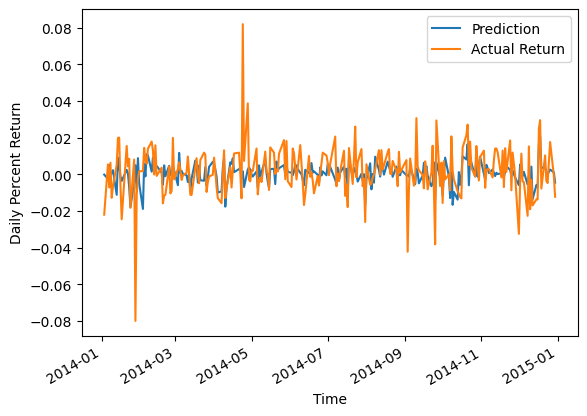

In [4]:
predictions = R_F + AAPL_beta*(M - R_F) # CAPM equation

predictions.plot()
R.plot()
plt.legend(['Prediction', 'Actual Return'])

plt.xlabel('Time')
plt.ylabel('Daily Percent Return')

### Supuestos del CAPM

En nuestra derivación del CAPM, hacemos **dos supuestos principales**:

1. **Mercado sin fricciones:**  
   - Se asume que los inversores pueden **operar sin demora ni costo**.  
   - Todos pueden **prestar o pedir prestado dinero a la tasa libre de riesgo**.

2. **Optimizadores de media-varianza:**  
   - Se asume que todos los inversores solo demandarán **portafolios que ofrezcan el mayor retorno posible para un nivel dado de riesgo**.  
   - Estos portafolios se encuentran a lo largo de la **frontera eficiente**.

A continuación, se muestra una **derivación programática de la frontera eficiente** para portafolios de cuatro activos.

(Es un código pesado, no te asustes si tarda unos minutos)

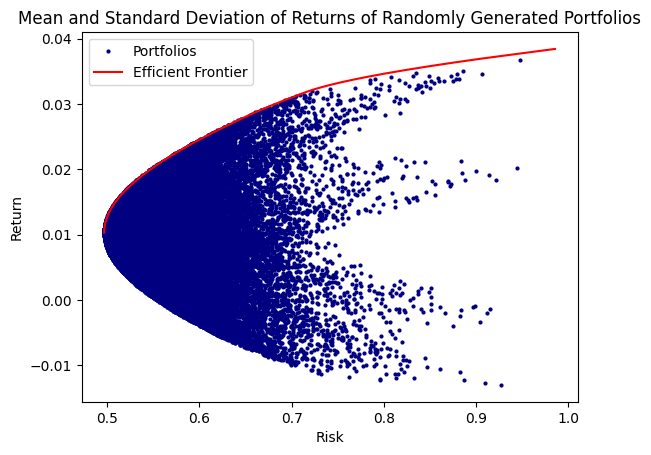

In [5]:
import numpy as np
from scipy import optimize
import cvxopt as opt
from cvxopt import blas, solvers

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

# Number of assets
n_assets = 4

# Number of observations
n_obs = 2000

## Generating random returns for our 4 securities
return_vec = np.random.randn(n_assets, n_obs)

def rand_weights(n):
    ''' 
    Produces n random weights that sum to 1 
    '''
    k = np.random.rand(n)
    return k / sum(k)

def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

def optimal_portfolios(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100000
    
    # Creating a list of returns to optimize the risk for
    mus = [100**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    
    ## Calculate the risk and returns of the frontier
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    
    return returns, risks

n_portfolios = 50000

means, stds = np.column_stack([random_portfolio(return_vec) for x in range(n_portfolios)])

returns, risks = optimal_portfolios(return_vec)

plt.plot(stds, means, 'o', markersize=2, color='navy')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.title('Mean and Standard Deviation of Returns of Randomly Generated Portfolios')

plt.plot(risks, returns, '-', markersize=3, color='red')
plt.legend(['Portfolios', 'Efficient Frontier'])

Cada punto azul representa un **portafolio diferente**, mientras que la **línea roja** que recorre el borde exterior de la nube es la **frontera eficiente**.  

La **frontera eficiente** contiene todos los portafolios que son **óptimos para un nivel dado de riesgo**.


El portafolio **óptimo** o más eficiente en esta línea se encuentra **maximizando el Sharpe ratio**, que es la razón entre el **retorno excedente** y la **volatilidad**.  
- Esto se usa para determinar el portafolio con la mejor relación **riesgo-recompensa**.  

La línea que representa las diferentes combinaciones de un **activo libre de riesgo** con un portafolio de activos riesgosos se conoce como la **Capital Allocation Line (CAL)**.  
- La **pendiente de la CAL** es el **Sharpe ratio**.  
- Para maximizar el Sharpe ratio, necesitamos encontrar la **CAL más inclinada**, que coincide con la CAL **tangente a la frontera eficiente**.  

Por eso, el portafolio eficiente a veces se llama **portafolio tangente**.


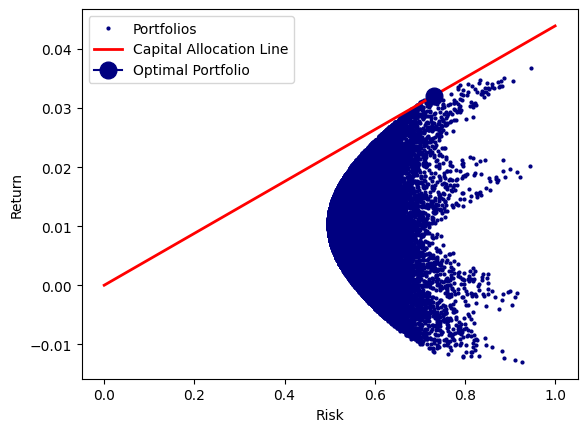

In [6]:
def maximize_sharpe_ratio(return_vec, risk_free_rate):
    """
    Finds the CAPM optimal portfolio from the efficient frontier 
    by optimizing the Sharpe ratio.
    """
    
    def find_sharpe(weights):
        
        means = [np.mean(asset) for asset in return_vec]
        
        numerator = sum(weights[m]*means[m] for m in range(len(means))) - risk_free_rate
        
        weight = np.array(weights)
        
        denominator = np.sqrt(weights.T.dot(np.corrcoef(return_vec).dot(weights)))
        
        return numerator/denominator
    
    guess = np.ones(len(return_vec)) / len(return_vec)
    
    def objective(weights):
        return -find_sharpe(weights)
    
    # Set up equality constrained
    cons = {'type':'eq', 'fun': lambda x: np.sum(np.abs(x)) - 1} 

    # Set up bounds for individual weights
    bnds = [(0, 1)] * len(return_vec)
    
    results = optimize.minimize(objective, guess,
                            constraints=cons, bounds=bnds, 
                            method='SLSQP', options={'disp': False})
    
    return results

risk_free_rate = np.mean(R_F)

results = maximize_sharpe_ratio(return_vec, risk_free_rate)

# Applying the optimal weights to each assset to get build portfolio
optimal_mean = sum(results.x[i]*np.mean(return_vec[i]) for i in range(len(results.x)))

optimal_std = np.sqrt(results.x.T.dot(np.corrcoef(return_vec).dot(results.x)))

# Plot of all possible portfolios
plt.plot(stds, means, 'o', markersize=2, color='navy')
plt.ylabel('Return')
plt.xlabel('Risk')

# Line from the risk-free rate to the optimal portfolio
eqn_of_the_line = lambda x : ( (optimal_mean-risk_free_rate) / optimal_std ) * x + risk_free_rate    

xrange = np.linspace(0., 1., num=11)

plt.plot(xrange, [eqn_of_the_line(x) for x in xrange], color='red', linestyle='-', linewidth=2)

# Our optimal portfolio
plt.plot([optimal_std], [optimal_mean], marker='o', markersize=12, color="navy")

plt.legend(['Portfolios', 'Capital Allocation Line', 'Optimal Portfolio'])

## Teoría de Valoración por Arbitraje (APT)

El **CAPM**, aunque ampliamente usado, tiene limitaciones debido a sus supuestos estrictos.  
La **Arbitrage Pricing Theory (APT)** generaliza el CAPM, considerando que los activos pueden estar expuestos a **varias clases de riesgo**, no solo al riesgo de mercado, y que los inversores pueden interesarse por más que la media y la varianza.

---

#### Modelo de factores lineales

APT expresa los retornos mediante un **modelo lineal de factores**:

$$
R_i = R_f + \sum_k \beta_{ik} F_k + \epsilon_i
$$

- Un **factor** es un flujo de retornos determinado por alguna característica específica.  
- Por ejemplo, el CAPM tiene un solo factor: el **retorno del mercado**.  

El retorno esperado toma la forma:

$$
E[R_i] = R_f + \sum_k \beta_{ik} \lambda_k
$$

donde:  
- $R_f$ es la tasa libre de riesgo  
- $\lambda_k$ es la **prima de riesgo** para el factor $k$  

La prima surge porque los inversores requieren **mayores retornos para asumir mayor riesgo**.  
- Las primas de riesgo pueden estimarse con **regresión Fama-Macbeth** u otros métodos.

---

#### Arbitraje

- En un universo con muchos activos, si los **retornos esperados no son consistentes**, existen **oportunidades de arbitraje**: operaciones **sin riesgo y sin inversión neta** que generan ganancias esperadas positivas.  

La APT **asume que los arbitrajistas ajustarán los precios** hasta que las oportunidades desaparezcan, justificando el uso de **modelos de factores empíricos** en la valoración de activos.


### Probando la Teoría de Valoración por Arbitraje (APT)

La mayoría de las pruebas empíricas de la **APT** se realizan en **dos pasos**:  
1. Estimar las **betas** de los factores individuales.  
2. Compararlas con los **precios reales** para evaluar qué tan bien se cumplieron las predicciones.  
